Plot time series of domain integrated KE and APE as well as SSH standard deviation with respect to a 2000-day climatology.

In [1]:
import numpy as np
import xarray as xr
import cmocean as cmocean
import numpy.linalg as la
from scipy.io import netcdf
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from xgcm import Grid
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from matplotlib.colors import SymLogNorm, BoundaryNorm
from matplotlib.ticker import LogFormatter
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator


mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman']

In [2]:
def get_colors_from_cmap(cmap_name, n_colors):
    cmap = cm.get_cmap(cmap_name)
    return [cmap(i / (n_colors - 1)) for i in range(n_colors)]

blues   = get_colors_from_cmap('Blues', 10)
reds = ['#f69a8b', '#b91a38']
greys = get_colors_from_cmap('Greys', 10)

colorlist_p5 = [blues[4], reds[0]]
colorlist_p25 = [blues[8], reds[1]]
colorlist_p03125 = [greys[3], greys[5], 'k']

/state/partition1/job-65577589/ipykernel_3400302/3569882092.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


#### Energies

In [3]:
root = '/scratch/mp6191/NW2_TracerBackscatter'

# 1/32 Spin Up

exp = '/p25_noBS_SpinUp'
os_p25 = xr.concat([xr.open_dataset(root + exp + '/ocean.stats.nc'),
                    xr.open_dataset(root + exp + '/ocean.stats_1.nc'),
                    xr.open_dataset(root + exp + '/ocean.stats_2.nc'),
                    xr.open_dataset(root + exp + '/ocean.stats_3.nc'),
                    xr.open_dataset(root + exp + '/ocean.stats_4.nc'),
                    xr.open_dataset(root + '/p25_noBS/ocean.stats.nc'),
                    xr.open_dataset(root + '/p25_noBS_2/ocean.stats.nc'),
                    ], dim = 'Time')

exp = '/p125_SpinUp'
os_p125 = xr.open_dataset(root + exp + '/ocean.stats.nc')
os_p125 = os_p125.assign_coords({'Time': os_p125.Time + xr.open_dataset(root + '/p25_noBS_SpinUp/ocean.stats_2.nc').Time[-1].item()})

exp = '/p0625_SpinUp'
os_p0625 = xr.open_dataset(root + exp + '/ocean.stats.nc')
os_p0625 = os_p0625.assign_coords({'Time': os_p0625.Time + os_p125.Time[-1].item()})


exp = '/p03125_SpinUp'
os_p03125 = xr.concat([xr.open_dataset(root + exp + '/ocean.stats.nc'),
                       xr.open_dataset(root + '/p03125/ocean.stats.nc')],
                      dim = 'Time')
os_p03125 = os_p03125.assign_coords({'Time': os_p03125.Time + os_p0625.Time[-1].item()})
os_p03125_2 = xr.concat([xr.open_dataset(root + '/p03125_SpinUp_2/ocean.stats.nc').drop_vars('dye001'),
                         xr.open_dataset(root + '/p03125_2/ocean.stats.nc').isel(Time = slice(0, 60)).drop_vars('dye001'),
                         xr.open_dataset(root + '/p03125_2/ocean.stats_1.nc').drop_vars('dye001'),
                         xr.open_dataset(root + '/p03125_2/ocean.stats_2.nc').isel(Time = slice(None, -1)).drop_vars('dye001'),
                         xr.open_dataset(root + '/p03125_2/ocean.stats_3.nc')
                        ], dim = 'Time', data_vars = 'minimal')
os_p03125_2 = os_p03125_2.assign_coords({'Time': os_p03125_2.Time + os_p03125.Time[-1].item()})
os_p03125 = xr.concat([os_p03125, os_p03125_2], dim = 'Time')

# 1/2 deg runs
exp = '/p5_noBS_KHTR0_SpinUp'
os_p5noBS = xr.concat([xr.open_dataset(root + exp + '/ocean.stats.nc').isel(Time = slice(0, 2000)),
                    xr.open_dataset(root + exp + '/ocean.stats_1.nc'),
                    xr.open_dataset(root + exp + '/ocean.stats_2.nc'),
                    xr.open_dataset(root + exp + '/ocean.stats_3.nc'),
                    xr.open_dataset(root + exp + '/ocean.stats_4.nc'),
                    xr.open_dataset(root + '/p5_noBS_KHTR0/ocean.stats.nc'),
                    xr.open_dataset(root + '/p5_noBS_KHTR0_2/ocean.stats.nc')
                    ], dim = 'Time')


exp = '/p5_SQGBS_KHTR0_SpinUp'
os_p5SQGBS = xr.concat([xr.open_dataset(root + exp + '/ocean.stats.nc'),
                        xr.open_dataset(root + exp + '/ocean.stats_1.nc'),
                        xr.open_dataset(root + '/p5_SQGBS_KHTR0/ocean.stats.nc'),
                        xr.open_dataset(root + '/p5_SQGBS_KHTR0_2/ocean.stats.nc')
                        ], dim = 'Time')

# 1/4 deg
exp = '/p25_SQGBS_KHTR0_SpinUp'

os_p25SQGBS = xr.concat([xr.open_dataset(root + exp + '/ocean.stats.nc'),
                    xr.open_dataset(root + exp + '/ocean.stats_1.nc'),
                    xr.open_dataset(root + '/p25_SQGBS/ocean.stats.nc'),
                    xr.open_dataset(root + '/p25_SQGBS_2/ocean.stats.nc')
                    ], dim = 'Time')

# test
exp = '/p25_SQGBS_SQGexp2p5_SpinUp'
os_p25SQGBS_SQGexp2p5 = xr.open_dataset(root + exp + '/ocean.stats.nc')

/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Ser

#### SSH

In [4]:
exp = '/p5_noBS_KHTR0_2'
p5_noBS = xr.open_mfdataset(root + exp + '/snapshots*.nc', decode_times = False)
p5_noBS_h = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time')
p5_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)
p5_eta = xr.open_dataset(root + exp + '/MOM_IC.nc', decode_times = False)

exp = '/p5_SQGBS_KHTR0_2'
p5_SQGBS = xr.open_mfdataset(root + exp + '/snapshots*.nc', decode_times = False)
p5_SQGBS_h = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time')

exp = '/p25_noBS_2'
p25_noBS = xr.open_mfdataset(root + exp + '/snapshots*.nc', decode_times = False)
p25_noBS_h = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time')
p25_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)
p25_eta = xr.open_dataset(root + '/p25_SpinUp' + '/MOM_IC.nc', decode_times = False)

exp = '/p25_SQGBS_2'
p25_SQGBS = xr.open_mfdataset(root + exp + '/snapshots*.nc', decode_times = False)
p25_SQGBS_h = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time')

exp = '/p03125_2'
p03125 = xr.open_mfdataset(root + exp + '/snapshots*.nc', decode_times = False)
p03125_h = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time')
p03125_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)
p03125_eta = xr.open_dataset('/scratch/mp6191/NW2_TracerBackscatter/p03125_IC/MOM_IC_4.nc', decode_times = False)

/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Ser

In [5]:
p5_grid = Grid(p5_noBS, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                  'Y': {'center': 'yh', 'outer': 'yq'}})

p25_grid = Grid(p25_noBS, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                    'Y': {'center': 'yh', 'outer': 'yq'}})

p03125_grid = Grid(p03125, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                     'Y': {'center': 'yh', 'outer': 'yq'}})

Re = 6.37e6

In [6]:
def thickness_to_eta(ds, static, eta):
    '''
    Converts thickness to eta
    '''
    xh = ds.xh.values
    yh = ds.yh.values
    zi = eta.Interface.values
    time = ds.time.values
    shape = (time.size, zi.size, yh.size, xh.size)
    e = xr.DataArray(data = np.zeros(shape),
                     dims = ['time', 'zi', 'yh', 'xh'], 
                     coords = {'xh' : xh, 'yh' : yh, 'zi' : zi, 'time' : time}).rename('eta')

    D = static.depth_ocean.load()
    h = ds.h.load()
    for k in range(zi.size):
        e[:, k, :, :] = h.isel(zl = slice(k, None)).sum('zl', skipna = False) - D

    return e

def clim_thickness_to_eta(ds, static, eta):
    '''
    Converts a climatological thickness to eta
    '''
    xh = ds.xh.values
    yh = ds.yh.values
    zi = eta.Interface.values
    shape = (zi.size, yh.size, xh.size)
    e = xr.DataArray(data = np.zeros(shape),
                     dims = ['zi', 'yh', 'xh'], 
                     coords = {'xh' : xh, 'yh' : yh, 'zi' : zi}).rename('eta')

    D = static.depth_ocean.load()
    h = ds.load()
    for k in range(zi.size):
        e[k, :, :] = h.isel(zl = slice(k, None)).sum('zl', skipna = False) - D

    return e

def calc_SSH_anom(ds, ds_h, static, eta):
    '''
    Returns SSH anom
    '''

    ssh = thickness_to_eta(ds, static, eta).isel(zi = 0)
    ssh_clim = clim_thickness_to_eta(ds_h, static, eta).isel(zi = 0)
    ssh_anom = ssh - ssh_clim

    return ssh_anom

In [7]:
p5_noBS_SSH_anom = calc_SSH_anom(p5_noBS, p5_noBS_h, p5_static, p5_eta)
p5_SQGBS_SSH_anom = calc_SSH_anom(p5_SQGBS, p5_SQGBS_h, p5_static, p5_eta)

p25_noBS_SSH_anom = calc_SSH_anom(p25_noBS, p25_noBS_h, p25_static, p25_eta)
p25_SQGBS_SSH_anom = calc_SSH_anom(p25_SQGBS, p25_SQGBS_h, p25_static, p25_eta)

In [ ]:
### do 1/32 deg separately:

# climatology
ds = p03125_h
static = p03125_static
eta = p03125_eta

xh = ds.xh.values
yh = ds.yh.values
shape = (yh.size, xh.size)
p03125_SSH_clim = xr.DataArray(data = np.zeros(shape),
                               dims = ['yh', 'xh'], 
                               coords = {'xh' : xh, 'yh' : yh}).rename('eta')

D = p03125_static.depth_ocean.load()
h = ds.load()
p03125_SSH_clim[:, :] = h.sum('zl', skipna = False) - D

# anomaly
ds = p03125
static = p03125_static
eta = p03125_eta

xh = ds.xh.values
yh = ds.yh.values
time = ds.time.values
shape = (time.size, yh.size, xh.size)
p03125_SSH = xr.DataArray(data = np.zeros(shape),
                          dims = ['time', 'yh', 'xh'], 
                          coords = {'xh' : xh, 'yh' : yh, 'time' : time}).rename('eta')

D = p03125_static.depth_ocean.load()
for t in range(time.size):
    h = ds.h.isel(time = t).load()
    p03125_SSH[t, :, :] = h.sum('zl', skipna = False) - D

p03125_SSH_anom = p03125_SSH - p03125_SSH_clim

#### Plot

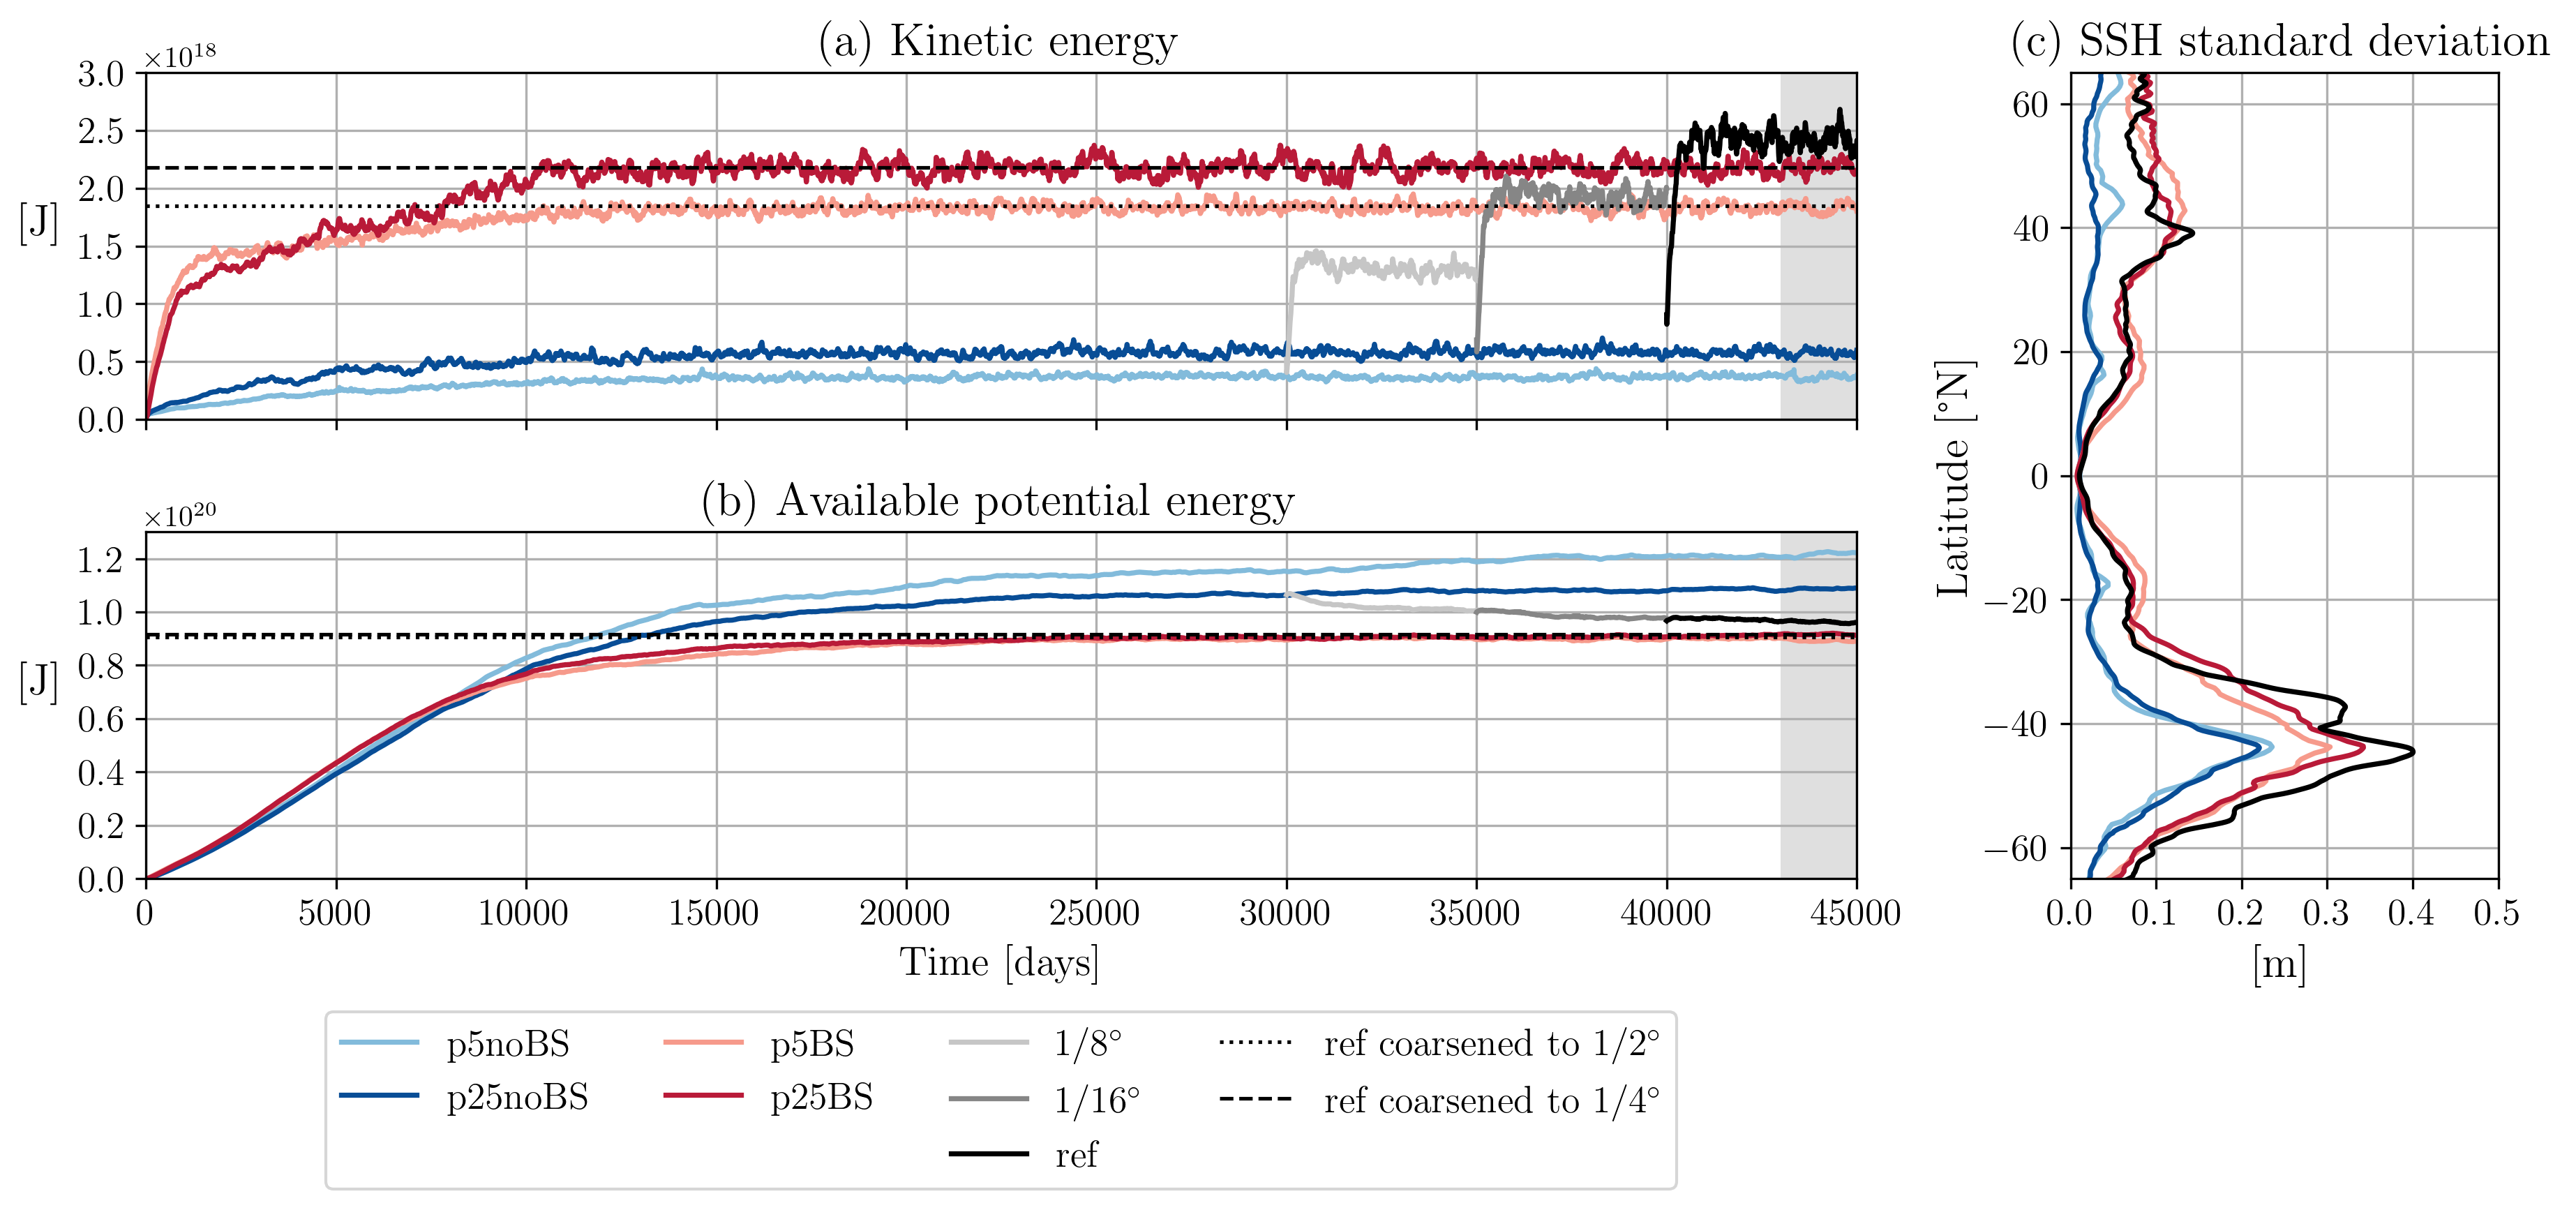

In [13]:
fig = plt.figure(figsize=(14.5, 5), dpi = 300)
fontsize = 15
linewidth = 1.75
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[4, 1])  # 4:1 width ratio for wide left, skinny right

# Left column
ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax2 = fig.add_subplot(gs[1, 0])  # Bottom-left
ax3 = fig.add_subplot(gs[:, 1])  # Right, spanning both rows

tmin = 0
tmax = 45000
t = np.linspace(tmin, tmax, 101)

analysis_reg_min = 43000
analysis_reg_max = 45000

KE_p03125_p5 = 1.85e18
APE_p03125_p5 = 9.06e19
En_p03125_p5 = KE_p03125_p5 + APE_p03125_p5

KE_p03125_p25 = 2.18e18
APE_p03125_p25 = 9.16e19
En_p03125_p25 = KE_p03125_p25 + APE_p03125_p25


### KE
ax = ax1
ax.plot(os_p5noBS.Time / 86400 / 1e9, os_p5noBS.KE.sum('Layer'), label = '1/2° unparameterized', color = colorlist_p5[0], linewidth = linewidth)
ax.plot(os_p25.Time / 86400 / 1e9, os_p25.KE.sum('Layer'), label = '1/4° unparameterized', color = colorlist_p25[0], linewidth = linewidth)

ax.plot(os_p5SQGBS.Time / 86400 / 1e9, os_p5SQGBS.KE.sum('Layer'), label = '1/2° backscatter', color = colorlist_p5[1], linewidth = linewidth)
ax.plot(os_p25SQGBS.Time / 86400 / 1e9, os_p25SQGBS.KE.sum('Layer'), label = '1/4° backscatter', color = colorlist_p25[1], linewidth = linewidth)

ax.plot(os_p125.Time / 86400 / 1e9, os_p125.KE.sum('Layer'), label = '1/8°', color = colorlist_p03125[0], linewidth = linewidth)
ax.plot(os_p0625.Time / 86400 / 1e9, os_p0625.KE.sum('Layer'), label = '1/16°', color = colorlist_p03125[1], linewidth = linewidth)
ax.plot(os_p03125.Time / 86400 / 1e9, os_p03125.KE.sum('Layer'), label = '1/32°', color = colorlist_p03125[2], linewidth = linewidth)

ax.plot(t, t * 0 + KE_p03125_p5, label = '1/32° coarsened to 1/2°', linestyle = ':', color = 'k', linewidth = linewidth - 0.5)
ax.plot(t, t * 0 + KE_p03125_p25, label = '1/32° coarsened to 1/4°', linestyle = '--', color = 'k', linewidth = linewidth - 0.5)

ax.axvspan(analysis_reg_min, analysis_reg_max, alpha = 0.5, color = 'silver', linewidth = 0)

ax.set_ylim((0, 3e18))
ax.set_xlim((tmin, tmax))
ax.set_xlabel('',fontsize = fontsize - 1)
ax.set_ylabel('[J]', fontsize = fontsize, rotation = 0, labelpad = 12)
ax.tick_params(axis = 'both', labelsize = fontsize - 2)
ax.set_yticks(np.linspace(0., 3.0e18, 7))
ax.set_title('(a) Kinetic energy', fontsize = fontsize + 1)
ax.grid()
ax.tick_params(labelbottom = False)


### APE
ax = ax2

ax.plot(os_p5noBS.Time / 86400 / 1e9, os_p5noBS.APE.sum('Interface'), label = 'p5noBS', color = colorlist_p5[0], linewidth = linewidth)
ax.plot(os_p25.Time / 86400 / 1e9, os_p25.APE.sum('Interface'), label = 'p25noBS', color = colorlist_p25[0], linewidth = linewidth)
ax.plot(np.zeros(1), np.zeros([1]), color='w', alpha=0, label=' ')

ax.plot(os_p5SQGBS.Time / 86400 / 1e9, os_p5SQGBS.APE.sum('Interface'), label = 'p5BS', color = colorlist_p5[1], linewidth = linewidth)
ax.plot(os_p25SQGBS.Time / 86400 / 1e9, os_p25SQGBS.APE.sum('Interface'), label = 'p25BS', color = colorlist_p25[1], linewidth = linewidth)
ax.plot(np.zeros(1), np.zeros([1]), color='w', alpha=0, label=' ')

ax.plot(os_p125.Time / 86400 / 1e9, os_p125.APE.sum('Interface'), label = '1/8$^\circ$', color = colorlist_p03125[0], linewidth = linewidth)
ax.plot(os_p0625.Time / 86400 / 1e9, os_p0625.APE.sum('Interface'), label = '1/16$^\circ$', color = colorlist_p03125[1], linewidth = linewidth)
ax.plot(os_p03125.Time / 86400 / 1e9, os_p03125.APE.sum('Interface'), label = 'ref', color = colorlist_p03125[2], linewidth = linewidth)

ax.plot(t, t * 0 + APE_p03125_p5, label = 'ref coarsened to 1/2$^\circ$', linestyle = ':', color = 'k', linewidth = linewidth - 0.5)
ax.plot(t, t * 0 + APE_p03125_p25, label = 'ref coarsened to 1/4$^\circ$', linestyle = '--', color = 'k', linewidth = linewidth - 0.5)
ax.plot(np.zeros(1), np.zeros([1]), color='w', alpha=0, label=' ')

ax.axvspan(analysis_reg_min, analysis_reg_max, alpha = 0.5, color = 'silver', linewidth = 0)

ax.set_ylim((0.e20, 1.3e20))
ax.set_xlim((tmin, tmax))
ax.set_xlabel('Time [days]',fontsize = fontsize - 1)
ax.set_ylabel('[J]', fontsize = fontsize, rotation = 0, labelpad = 12)
ax.tick_params(axis = 'both', labelsize = fontsize - 2)
ax.set_yticks(np.linspace(0., 1.2e20, 7))
ax.set_title('(b) Available potential energy', fontsize = fontsize + 1)
ax.grid()
ax.legend(fontsize = fontsize - 2, loc = 'lower center', ncol = 4, bbox_to_anchor = (0.5, -0.95))


### SSH
ax = ax3

p5_noBS_SSH_anom.std('time').mean('xh').plot(y = 'yh', color = colorlist_p5[0], linewidth = linewidth)
p25_noBS_SSH_anom.std('time').mean('xh').plot(y = 'yh', color = colorlist_p25[0], linewidth = linewidth)
p5_SQGBS_SSH_anom.std('time').mean('xh').plot(y = 'yh', color = colorlist_p5[1], linewidth = linewidth)
p25_SQGBS_SSH_anom.std('time').mean('xh').plot(y = 'yh', color = colorlist_p25[1], linewidth = linewidth)
p03125_SSH_anom.std('time').mean('xh').plot(y = 'yh', color = colorlist_p03125[2], linewidth = linewidth)

ax.grid()
ax.set_xlabel('[m]', fontsize = fontsize)
ax.set_ylabel('Latitude [°N]', fontsize = fontsize, labelpad = 2)
ax.set_title('(c) SSH standard deviation', fontsize = fontsize + 1)
ax.set_ylim([-65, 65])
ax.set_xlim([0, 0.5])
ax.set_xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])
ax.tick_params(axis = 'both', labelsize = fontsize - 2)

plt.subplots_adjust(hspace = 0.325, wspace = 0.2)
plt.savefig('Fig_APE_KE_SSH.pdf', bbox_inches = 'tight', dpi = 300)